In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

from scipy import stats
from scipy.stats import spearmanr

In [305]:
# read in data
df_eng = pd.read_csv('tutor_data.csv').drop(columns='Unnamed: 0')
df_eng.reset_index(drop=True, inplace=True)
#df_eng.drop_duplicates(inplace=True)

df_nlp = pd.read_csv('tutor_nlp.csv')
df_eng = pd.concat([df_eng, df_nlp], axis=1)

# cuts on targets
#df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] < 20].index]
#df_eng = df_eng.loc[df_eng[df_eng['hours_per_week_estimate'] > 0.5].index]

#df_eng = df_eng.loc[df_eng[df_eng['rate'] <= 200].index]
#df_eng = df_eng.loc[df_eng[df_eng['rate'] >= 20].index]

#df_eng = df_eng.loc[df_eng[df_eng['hours_tutor'] <= 1000].index]

In [306]:
df_eng.hours_tutor.describe()

count     4484.00000
mean       563.01182
std       1047.21002
min          1.00000
25%         51.00000
50%        172.00000
75%        596.25000
max      14999.00000
Name: hours_tutor, dtype: float64

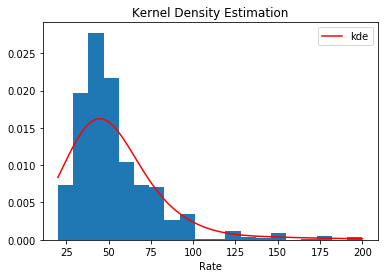

In [308]:
plt.hist(df_eng.rate, bins=20, range=(20,200), density=True)
plt.xlabel('Rate')
gkde = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=None)
ind = np.linspace(20, 200, 101)
kdepdf = gkde.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf, label='kde', color="r")
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [309]:
def string_to_list(i):
    x = i.replace('[', '').replace(']', '').replace('\'', '').split(',')
    list_i = list()
    for j in x:
        list_i.append(j.lstrip().rstrip())
    return list_i

subjects_all_list = []
for i in df_eng['subjects_all']:
    subjects_all_list.append(string_to_list(i))
df_eng['subjects_list'] = np.array(subjects_all_list)

subjects_emph_list = []
for i in df_eng['subjects_emph']:
    subjects_emph_list.append(string_to_list(i))
df_eng['subjects_emph_list'] = np.array(subjects_emph_list)

#edu_list = []
#for i in df_eng['edu']:
#    edu_list.append(string_to_list(i))
#df_eng['edu_list'] = np.array(edu_list)

# engineer subjects categories

feature = 'subjects_list'
size_subjects = len(df_eng[feature].explode().value_counts().index)
popular_subjects = list(df_eng[feature].explode().value_counts().index[:size_subjects//3])
mid_subjects = list(df_eng[feature].explode().value_counts().index[size_subjects//3:(size_subjects//3 + size_subjects//3)])
unpopular_subjects = list(df_eng[feature].explode().value_counts().index[(size_subjects//3 + size_subjects//3):])

unwanted = ''
if unwanted in popular_subjects:
    popular_subjects.remove(unwanted)
elif unwanted in mid_subjects:
    mid_subjects.remove(unwanted)
elif unwanted in unpopular_subjects:
    unpopular_subjects.remove(unwanted)

popular_list = []
mid_list = []
unpopular_list = []
for f in df_eng[feature]:
    num_popular = 0
    num_mid = 0
    num_unpopular = 0
    for j in f:
        if j in popular_subjects:
            num_popular += 1
        elif j in mid_subjects:
            num_mid += 1
        elif j in unpopular_subjects:
            num_unpopular += 1
    popular_list.append(num_popular)
    mid_list.append(num_mid)
    unpopular_list.append(num_unpopular)
    
df_eng['num_popular_subjects'] = np.array(popular_list)
df_eng['num_mid_subjects'] = np.array(mid_list)
df_eng['num_unpopular_subjects'] = np.array(unpopular_list)

# engineer edu degree categories

undergrad = ['BA', 'B.A.', 'BS', 'B.S.', '']
postgrad = ['MS', 'M.S', 'MA', 'M.A', 'masters', 'Masters', 'CA', 'C.A', 
            'MBA', 'M.B.A', 'MD', 'M.D', 'PhD', 'Ph.D', 'Ph.D.', 'Graduate']
certified = ['education', 'Ced', 'certified']

undergrad_degree = []
postgrad_degree = []
certified_degree = []
for e in df_eng['edu']:
    undergrad_count = 0
    postgrad_count = 0
    certified_count = 0
    if any(x in e for x in undergrad):
        undergrad_count += 1
    if any(x in e for x in postgrad):
        postgrad_count += 1
    if any(x in e for x in certified):
        certified_count +=1
    undergrad_degree.append(undergrad_count)
    postgrad_degree.append(postgrad_count)
    certified_degree.append(certified_count)
df_eng['undergrad_degree'] = np.array(undergrad_degree)
df_eng['postgrad_degree'] = np.array(postgrad_degree)
df_eng['certified_degree'] = np.array(certified_degree)

# get university rankings
df_wur = pd.read_csv('world-university-rankings_cwurData.csv')
df_wur_select = df_wur[['institution', 'world_rank']]

list_of_top_schools = (list(df_wur_select['institution'][:30]) + 
['Berkeley', 'Caltech', 'Harvard', 'Yale', 'Princeton', 'MIT', 'Stanford'])

top_school = []
for e in df_eng['edu']:
    top = 0
    if any(x in e for x in list_of_top_schools):
        top += 1
    top_school.append(top)
df_eng['top_school'] = np.array(top_school)

df_eng['bio_count'] = df_eng['bio'].apply(lambda x: len(str(x).split(" ")))
df_eng['desc_count'] = df_eng['descriptions'].apply(lambda x: len(str(x).split(" ")))

In [310]:
cols_to_drop = ['descriptions', 'bio', 'subjects_list', 'subjects_emph_list', 
                'edu', 'bg_check_date', 'earliest_review_date', 
                'subjects_emph', 'subjects_all','hours_tutor', 
                'num_ratings', 'review_dates', 'earliest_date','undergrad_degree',
               'hours_mon', 'hours_tues', 'hours_wed', 'hours_thurs', 'hours_fri']


cols_importance = ['hours_thurs', 'hours_mon', 'hours_tues', 'hours_wed', 'hours_fri', 'hours_sat', 'hours_sun', 
                    'postgrad_degree', 'num_mid_subjects', 'num_unpopular_subjects', 'certified_degree', 
               'number_subjects', 'desc_count', 'goal_kw', 'experience_kw']

X = df_eng.drop(columns=(['rate', 'hours_per_week_estimate'] + cols_to_drop))
y = df_eng.rate

#Take the log of y
y_log = np.log10(y)

#rescale data
X = (X - X.min()) / (X.max()-X.min())

features = X.columns

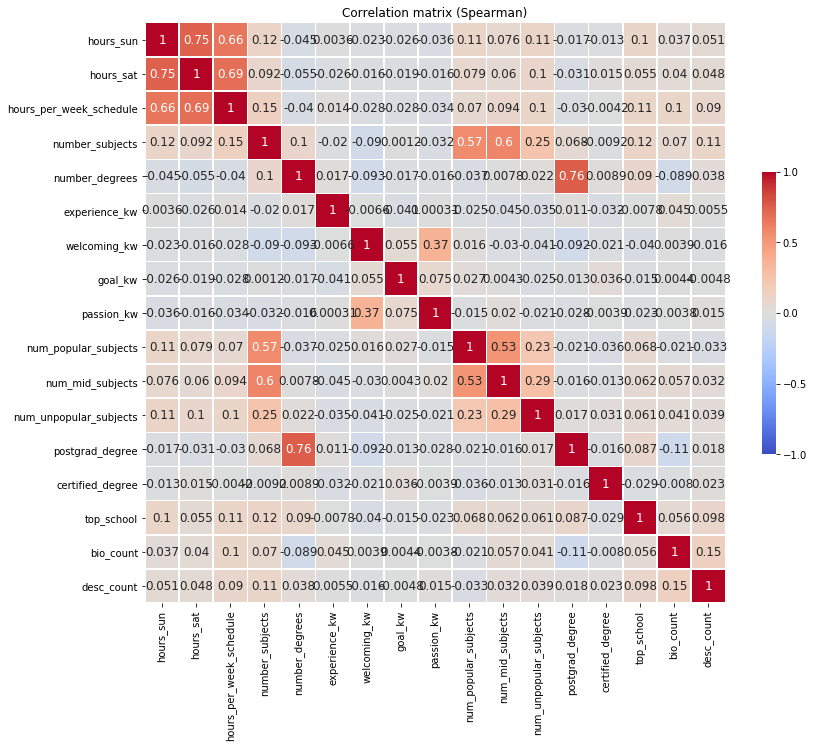

In [311]:
# Plot Spearman Correlation matrix

fig, ax = plt.subplots(figsize=(13, 13)) 

spearman_corr = pd.DataFrame(spearmanr(X).correlation, index=features, columns=features)

spearman_heatmap = sns.heatmap(spearman_corr,
                     square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})
ax.set_yticklabels(spearman_corr.columns, rotation = 0)
ax.set_xticklabels(spearman_corr.columns)
ax.set_title('Correlation matrix (Spearman)')
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

0.10734474256274651


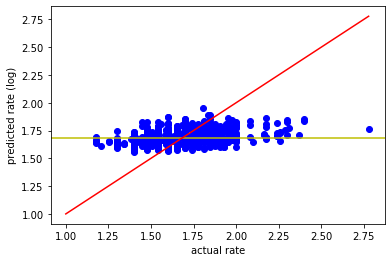

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
model = Ridge(alpha=1).fit(X_train, y_train)
y_predict = model.predict(X_test)

print(model.score(X_test, y_test))

plt.scatter(np.array(y_test), y_predict, color='b')
plt.axhline(y=y_log.mean(), color='y', linestyle='-')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')

plt.xlabel('actual rate')
plt.ylabel('predicted rate (log)')

plt.show()

r^2:  0.24305411936272114


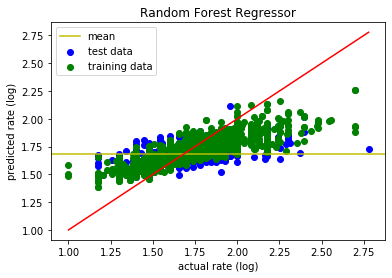

In [335]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
y_fit = rf.predict(X_train)

print('r^2: ', r2_score(y_test, y_predict))
plt.scatter(np.array(y_test), y_predict, color='b', label='test data')
plt.scatter(np.array(y_train), y_fit, color='g', label='training data')
plt.axhline(y=y_log.mean(), color='y', linestyle='-', label='mean')
x = np.linspace(y_log.min(), y_log.max(),100)
plt.plot(x, x, '-r')
plt.legend()
plt.title('Random Forest Regressor')
plt.xlabel('actual rate (log)')
plt.ylabel('predicted rate (log)')
plt.show()

Feature ranking:
feature number_subjects (0.14)
feature bio_count (0.14)
feature hours_per_week_schedule (0.12)
feature top_school (0.09)
feature num_popular_subjects (0.08)
feature hours_sun (0.07)
feature desc_count (0.07)
feature hours_sat (0.07)
feature welcoming_kw (0.05)
feature experience_kw (0.04)
feature num_mid_subjects (0.04)
feature number_degrees (0.03)
feature passion_kw (0.03)
feature postgrad_degree (0.01)
feature num_unpopular_subjects (0.01)
feature goal_kw (0.00)
feature certified_degree (0.00)


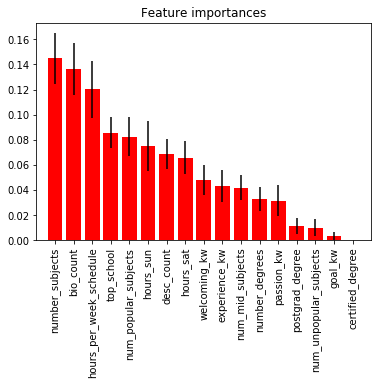

In [315]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
test = [features[f] for f in indices]
for f in range(X.shape[1]):
    print("feature %s (%.2f)" %(test[f], importances[indices[f]]))

# Plot feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), test, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [317]:
rf = RandomForestRegressor(n_estimators=100, criterion='mse', random_state=0, min_samples_leaf = 5)
features = list(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=0)
rf.fit(X_train, y_train)

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.1539 ± 0.0440,number_subjects
0.1214 ± 0.0407,top_school
0.0618 ± 0.0144,bio_count
0.0485 ± 0.0042,number_degrees
0.0475 ± 0.0063,desc_count
0.0401 ± 0.0085,hours_sat
0.0379 ± 0.0143,hours_sun
0.0333 ± 0.0057,hours_per_week_schedule
0.0318 ± 0.0065,num_mid_subjects
0.0312 ± 0.0033,num_popular_subjects


In [318]:
important_features = ['number_subjects', 'top_school', 'hours_per_week_schedule', 
'bio_count', 'number_degrees', 'desc_count', 'num_popular_subjects']

In [322]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_eng[important_features])
pca = PCA(n_components=3)
test_pca = pca.fit_transform(scaled_df)
print(pca.explained_variance_ratio_.sum())
pd.DataFrame(test_pca).describe()

input_test = np.array([-1, -1, -1])
weights_test = (1. / np.linalg.norm(input_test - test_pca, axis=-1))

0.5790240268443115


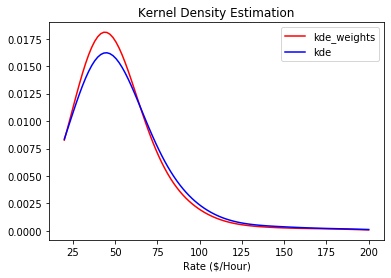

In [350]:
gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=weights_test)
#gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=np.ones(len(df_eng.rate)))
ind = np.linspace(20, 200, 101)
kdepdf_weights = gkde_weight.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf_weights, label='kde_weights', color="r")
plt.title('Kernel Density Estimation')
plt.xlabel('Rate ($/Hour)')
plt.plot(ind, kdepdf, label='kde', color='b')
plt.legend()
plt.show()

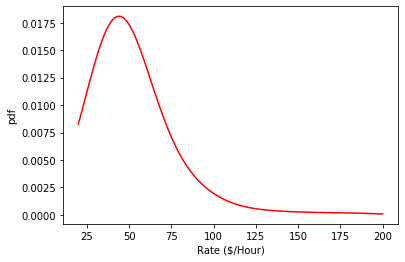

In [354]:
gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=weights_test)
#gkde_weight = stats.gaussian_kde(df_eng.rate, bw_method = 0.5, weights=np.ones(len(df_eng.rate)))
ind = np.linspace(20, 200, 101)
kdepdf_weights = gkde_weight.evaluate(ind)
#plt.figure()
plt.plot(ind, kdepdf_weights, color="r")
plt.xlabel('Rate ($/Hour)')
plt.ylabel('pdf')
#plt.plot(ind, kdepdf, label='kde', color='b')
plt.show()

Variance explained with 1 components: 0.2471809562815502
Variance explained with 2 components: 0.4216100826235055
Variance explained with 3 components: 0.5790240268443119
Variance explained with 4 components: 0.7093457045760188
Variance explained with 5 components: 0.831468709454086


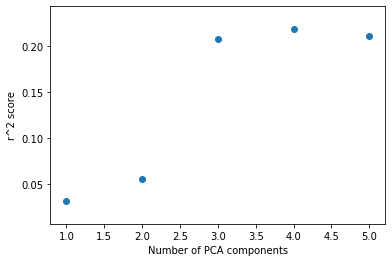

In [355]:
scaler = StandardScaler()
r2_scores = []
scaled_df = scaler.fit_transform(df_eng[important_features])
for i in range(1,6):
    pca = PCA(n_components=i)
    test_pca = pca.fit_transform(scaled_df)
    print('Variance explained with', i, 'components:',  pca.explained_variance_ratio_.sum())
    knn = KNeighborsRegressor(weights='distance', n_neighbors = 5)
    X_train, X_test, y_train, y_test = train_test_split(test_pca, y_log, test_size=0.2, random_state=0)
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    #print(i, ' features has a validation score ', r2_score(y_test, y_predict))
    r2_scores.append(r2_score(y_test, y_predict))

plt.scatter([1,2,3,4, 5], r2_scores)
plt.xlabel('Number of PCA components')
plt.ylabel('r^2 score')
plt.show()